
# MUSIC RECOMMENDER SYSTEM

DATA INFORMATION

In [1]:
from pyspark.sql import SparkSession
from time import time

In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Music Recommendation System") \
    .getOrCreate()

In [3]:
# Load data from Parquet
music_df = spark.read.parquet("hdfs:///mydata/cleaned_music_info.parquet")
history_df = spark.read.parquet("hdfs:///mydata/cleaned_user_listening_history.parquet")

In [4]:
# Show the first few rows of the music information DataFrame
print("Music Information DataFrame:")
music_df.show(5, truncate=False)

Music Information DataFrame:


+------------------+--------------+---------------+-----------------------------------------------------------------------------+-------+----+------------+------+--------+-----------+------------+----------------+--------+
|track_id          |name          |artist         |tags                                                                         |genre  |year|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|
+------------------+--------------+---------------+-----------------------------------------------------------------------------+-------+----+------------+------+--------+-----------+------------+----------------+--------+
|TRIOREW128F424EAF0|Mr. Brightside|The Killers    |rock, alternative, indie, alternative_rock, indie_rock, 00s                  |Unknown|2004|0.355       |0.918 |-4.36   |0.0746     |0.00119     |0.0             |0.0971  |
|TRUEIND128F93038C4|Take Me Out   |Franz Ferdinand|rock, alternative, indie, alternative_rock, indie_rock, b

In [5]:
# Show the first few rows of the user listening history DataFrame
print("User Listening History DataFrame:")
history_df.show(5 , truncate=False)

User Listening History DataFrame:


+------------------+----------------------------------------+---------+
|track_id          |user_id                                 |playcount|
+------------------+----------------------------------------+---------+
|TRDLMWP128F426BF6C|b80344d063b5ccb3212f76538f3d9e43d87dca9e|1        |
|TRMSZXT128F92F7816|b80344d063b5ccb3212f76538f3d9e43d87dca9e|1        |
|TRADEOV128F9330E3B|bd4c6e843f00bd476847fb75c47b4fb430a06856|1        |
|TRDOYFZ128F426E715|969cc6fb74e076a68e36a04409cb9d3765757508|1        |
|TRRELZC128E078ED67|4bd88bfb25263a75bbdd467e74018f4ae570e5df|6        |
+------------------+----------------------------------------+---------+
only showing top 5 rows



In [6]:
# Display the schema of Music Information DataFrames for verification
print("Music Information Schema:")
music_df.printSchema()

Music Information Schema:
root
 |-- track_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)



In [7]:
# Display the schema of User Listening History DataFrames for verification
print("User Listening History Schema:")
history_df.printSchema()

User Listening History Schema:
root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: integer (nullable = true)



# EXPLORATIVE DATA ANALYSIS

In [8]:
from pyspark.sql.functions import col, sum, coalesce, lit, max, min, countDistinct, desc, count, avg, when
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [9]:
# Get the shape, number of rows and columns, of the datasets
history_shape = (history_df.count(), len(history_df.columns))
music_shape = (music_df.count(), len(music_df.columns))

# Compute combined statistics for the history_df DataFrame
history_stats = history_df.agg(
    countDistinct("user_id").alias("unique_users"),  # Count unique users
    count(when(col("user_id").isNull(), 1)).alias("null_user_ids"),  # Count null user_id values
    max("playcount").alias("max_listen_count"),  # Maximum play count
    min("playcount").alias("min_listen_count")  # Minimum play count
).collect()[0]

# Compute combined statistics for the music_df DataFrame
music_stats = music_df.agg(
    countDistinct("name").alias("unique_songs"),  # Count unique song names
    count(when(col("name").isNull(), 1)).alias("null_song_titles"),  # Count null song title values
    countDistinct("artist").alias("unique_artists"),  # Count unique artists
    count(when(col("artist").isNull(), 1)).alias("null_artists")  # Count null artist values
).collect()[0]

# Extract statistics for history_df
unique_users = history_stats["unique_users"]
null_user_ids = history_stats["null_user_ids"]
max_listen_count = history_stats["max_listen_count"]
min_listen_count = history_stats["min_listen_count"]

# Extract statistics for music_df
unique_songs = music_stats["unique_songs"]
null_song_titles = music_stats["null_song_titles"]
unique_artists = music_stats["unique_artists"]
null_artists = music_stats["null_artists"]

# Print the computed statistics
print(f"""
Music Dataset's shape: {music_shape}
History Dataset's shape: {history_shape}

Number of unique ARTISTS: {unique_artists:,} \t Number of NULL artist values: {null_artists}
Number of unique USERS: {unique_users:,} \t Number of NULL user_id values: {null_user_ids}
Number of unique SONGS: {unique_songs:,} \t\t Number of NULL title values: {null_song_titles}

MAX no. of times a single song has been listened by a single user: {max_listen_count:,}
MIN no. of times a single song has been listened by a single user: {min_listen_count:,}
""")



Music Dataset's shape: (50681, 13)
History Dataset's shape: (9711301, 3)

Number of unique ARTISTS: 8,317 	 Number of NULL artist values: 0
Number of unique USERS: 962,037 	 Number of NULL user_id values: 0
Number of unique SONGS: 50,681 		 Number of NULL title values: 0

MAX no. of times a single song has been listened by a single user: 2,948
MIN no. of times a single song has been listened by a single user: 1



Join the two DataFrames on the "track_id" column


In [10]:
# Calculate cumulative playcount for each unique track_id in history_df
history_agg_df = history_df.groupBy("track_id").agg(
    sum("playcount").alias("popularity")
)

# Perform a left join with music_df to keep all tracks from music_df
df_music_p = music_df.join(history_agg_df, on="track_id", how="left")

#  Fill null values in total_playcount with 0
df_music_p = df_music_p.withColumn("popularity", coalesce(col("popularity"), lit(0)))

# Display the first few results
df_music_p.show(5, truncate=False)
print(df_music_p.count())


+------------------+--------------+---------------+-----------------------------------------------------------------------------+-------+----+------------+------+--------+-----------+------------+----------------+--------+----------+
|track_id          |name          |artist         |tags                                                                         |genre  |year|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|popularity|
+------------------+--------------+---------------+-----------------------------------------------------------------------------+-------+----+------------+------+--------+-----------+------------+----------------+--------+----------+
|TRIOREW128F424EAF0|Mr. Brightside|The Killers    |rock, alternative, indie, alternative_rock, indie_rock, 00s                  |Unknown|2004|0.355       |0.918 |-4.36   |0.0746     |0.00119     |0.0             |0.0971  |162       |
|TRVCCWR128F9304A30|Viva la Vida  |Coldplay       |rock, alterna

# IMPLEMENTING OUR RECOMMENDATION SYSTEM FILTERS:

1. RECOMMEND ARTISTS BASED ON POPULARITY AND SUGGEST SOME OF THE SONGS 

In [11]:
# Function to get top artists based on popularity
def get_top_artists(df, num_artists=5):
    # Group by artist and sum the popularity
    df_artist_popularity = df.groupBy("artist").agg(sum("popularity").alias("popularity"))
    
    # Sort by popularity in descending order and limit to the top artists
    df_top_artists = df_artist_popularity.orderBy("popularity", ascending=False).limit(num_artists)
    
    return df_top_artists

The provided function, recommend_songs_for_artists(), recommends top songs for a list of given artists by selecting a specified number of songs (num_songs_per_artist) for each artist based on song popularity.

In [12]:
# Function to recommend top songs for given artists
def recommend_songs_for_artists(df, artists, num_songs_per_artist=2):
    # Filter songs only for top artists and order by popularity
    artist_tracks_df = (
        df.filter(col("artist").isin(artists))
        .select("track_id", "name", "artist", "popularity")
        .orderBy(desc("popularity"))
    )

    # Iterate over artists to display their top songs
    for artist in artists:
        print(f"\nTop songs by {artist}:")
        artist_songs = artist_tracks_df.filter(col("artist") == artist).limit(num_songs_per_artist)
        artist_songs.show(truncate=False)

In [13]:
# Function to plot the popularity of top artists
def plot_top_artists(artists, popularity):
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    ax.bar(artists, popularity, color='lightgreen')
    
    # Add labels and title 
    ax.set_xlabel('Artist', color='white')
    ax.set_ylabel('Popularity', color='white')
    ax.set_title(f'Top {len(artists)} Popular Singers', color='white')
    
    # Rotate the x-axis labels
    plt.xticks(rotation=90, color='white')
    
    # Show gridlines 
    ax.grid(True, axis='y', color='gray')
    
    # Add y-tick labels 
    ax.tick_params(axis='y', colors='white')
    
    # Tight layout to ensure everything fits well
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [14]:
# function to recommend popular artists and suggest songs
def recommend_popular_artists(df_music_p, num_artists=5, num_songs_per_artist=2):
    # Validate input
    if num_artists <= 0 or num_songs_per_artist <= 0:
        print("Number of artists and number of songs per artist must be greater than zero.")
        return

    # Cache the DataFrame to improve performance when used multiple times
    df_music_p = df_music_p.cache()
    
    # Get top artists
    df_top_artists = get_top_artists(df_music_p, num_artists)
    
    # Convert to Pandas for easier manipulation and visualization
    df_top_artists_pd = df_top_artists.toPandas()
    artists = df_top_artists_pd['artist'].tolist()
    popularity = df_top_artists_pd['popularity'].tolist()

    # Recommend songs for the top artists
    recommend_songs_for_artists(df_music_p, artists, num_songs_per_artist)

    # Plot the popularity of the top artists
    plot_top_artists(artists, popularity)


Top songs by Kings of Leon:


+------------------+----------------+-------------+----------+
|track_id          |name            |artist       |popularity|
+------------------+----------------+-------------+----------+
|TRONYHY128F92C9D11|Revelry         |Kings of Leon|527893    |
|TRVQTQG128F93073B0|Molly's Chambers|Kings of Leon|20761     |
+------------------+----------------+-------------+----------+


Top songs by The Black Keys:


+------------------+-------------------------+--------------+----------+
|track_id          |name                     |artist        |popularity|
+------------------+-------------------------+--------------+----------+
|TRFBNZN128F9340B0E|All Hands Against His Own|The Black Keys|33178     |
|TRRKXNQ128F9339002|I'll Be Your Man         |The Black Keys|28413     |
+------------------+-------------------------+--------------+----------+


Top songs by Justin Bieber:


+------------------+-----------------+-------------+----------+
|track_id          |name             |artist       |popularity|
+------------------+-----------------+-------------+----------+
|TRRVJCK12903CD2DCB|U Smile          |Justin Bieber|61568     |
|TRJJCJQ12903CD2DD3|That Should Be Me|Justin Bieber|49119     |
+------------------+-----------------+-------------+----------+


Top songs by Coldplay:
+------------------+-----------+--------+----------+
|track_id          |name       |artist  |popularity|
+------------------+-----------+--------+----------+
|TRFWGOJ128E0780C8B|In My Place|Coldplay|41433     |
|TRZCIWG128F4248B25|Lost!      |Coldplay|21071     |
+------------------+-----------+--------+----------+


Top songs by Radiohead:


+------------------+------------+---------+----------+
|track_id          |name        |artist   |popularity|
+------------------+------------+---------+----------+
|TRESMVD128F9310D57|(Nice Dream)|Radiohead|32962     |
|TRARTEH128F423DBC1|15 Step     |Radiohead|17822     |
+------------------+------------+---------+----------+



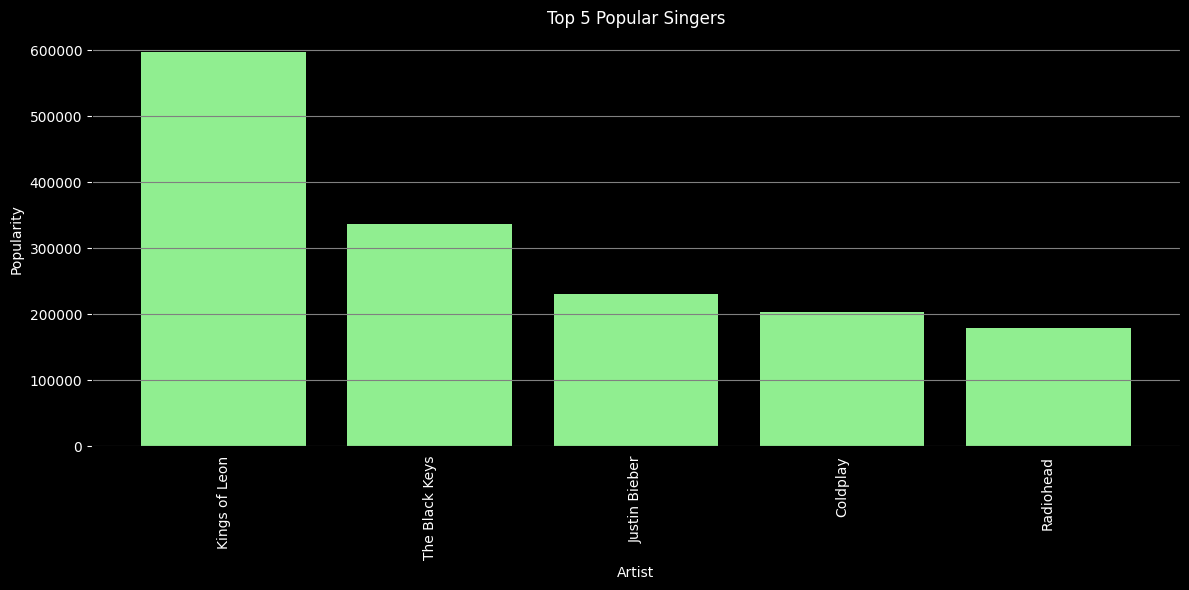

In [15]:
# Recommend the most popular artists and suggest some songs
recommend_popular_artists(df_music_p, num_artists=5, num_songs_per_artist=2)
# beforw it was more than 1 minute

2. RECOMMEND SONGS BASED ON THE MOST LISTENED TRACKS (TOP 10)

In [16]:
# Function to recommend songs based on the most listened tracks
def recommend_popular_songs(num_songs=5):
    # Calculate the most popular tracks
    popular_tracks_df = (
        history_df.groupBy("track_id")
        .agg(count("user_id").alias("playcount"))
        .join(music_df, on="track_id")
        .orderBy(desc("playcount"))
        .limit(num_songs)
    )

    # Check if the number of available tracks is less than the requested number
    available_tracks = popular_tracks_df.count()
    if available_tracks == 0:
        print("No tracks available.")
        return
    if available_tracks < num_songs:
        print(f"Only {available_tracks} track(s) available.")
    # Limit to the number of tracks available or the requested number
    limit_tracks = num_songs if available_tracks >= num_songs else available_tracks
    popular_tracks_df = popular_tracks_df.limit(limit_tracks)

    # Show the recommended tracks only if there are available tracks
    if available_tracks > 0:
        popular_tracks_df.select("track_id", "name", "artist").show(truncate=False)
    
    # Extract track names and play counts 
    data = popular_tracks_df.collect()
    track_names = [row['name'] for row in data]
    play_counts = [row['playcount'] for row in data]
    
    # Create a bar chart 
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    ax.bar(track_names, play_counts, color='blue', alpha=0.7)
    # Add labels and title
    ax.set_xlabel('Track Name', color='white')
    ax.set_ylabel('Play Count', color='white')
    ax.set_title(f'Top {num_songs} Most Popular Tracks', color='white')
    # Rotate the x-axis labels
    plt.xticks(rotation=90, color='white')
    # Show gridlines
    ax.grid(True, axis='y', color='gray')
    # Add y-tick labels
    ax.tick_params(axis='y', colors='white')
    # Tight layout 
    plt.tight_layout()
    # Show the plot
    plt.show()


+------------------+---------------------+-----------------+
|track_id          |name                 |artist           |
+------------------+---------------------+-----------------+
|TRONYHY128F92C9D11|Revelry              |Kings of Leon    |
|TRUFTBY128F93450B8|Alejandro            |Lady Gaga        |
|TRXWAZC128F9314B3E|Heartbreak Warfare   |John Mayer       |
|TRCPXID128F92D5D3C|Halo                 |Depeche Mode     |
|TRGCHLH12903CB7352|Party In The U.S.A.  |The Barden Bellas|
|TROMKCG128F9320C09|Uprising             |Sabaton          |
|TRPFYYL128F92F7144|Float On             |Modest Mouse     |
|TRPGPDK12903CCC651|Bring Me To Life     |Katherine Jenkins|
|TRWAQOC12903CB84CA|Sexy Bitch           |David Guetta     |
|TRAALAH128E078234A|Bitter Sweet Symphony|The Verve        |
+------------------+---------------------+-----------------+



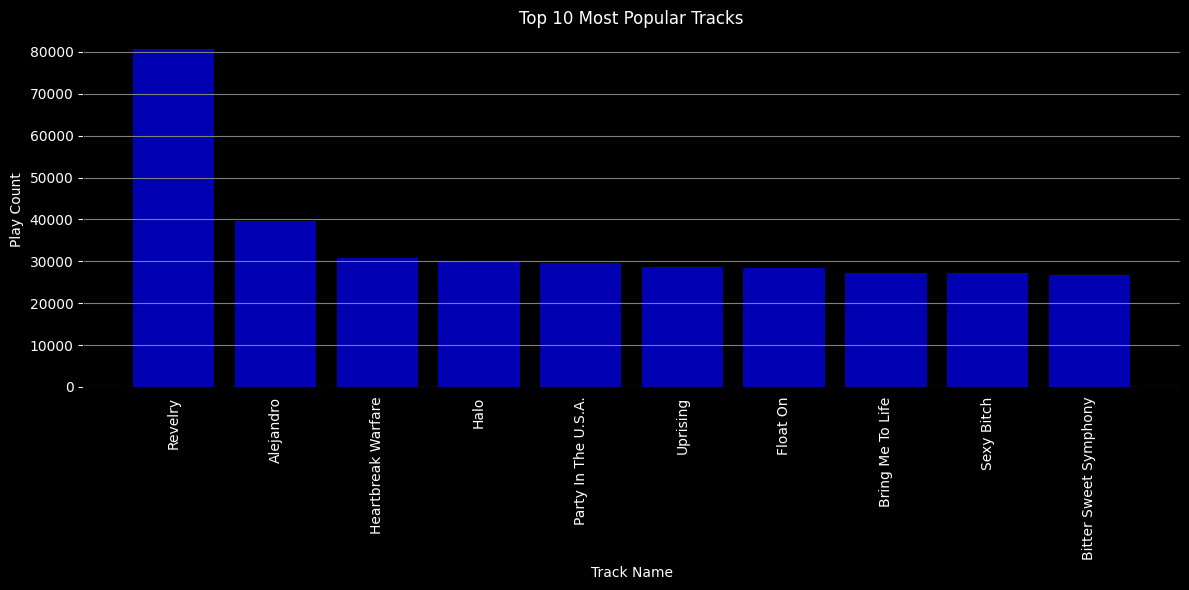

In [17]:
# Recommend the num_songs most popular tracks
recommend_popular_songs(num_songs=10)

3. RECOMMEND SONGS FOR A SPECIFIC USER BASED ON USER'S FEATURE AVERAGES

In [18]:
# Function to recommend songs for a specific user based on audio feature averages
def recommend_songs_based_on_user_preferences(user_id, num_songs=5):
    print(f"\nRecommendations for user: {user_id}")

    # Verify if the user_id exists in history_df
    if not history_df.filter(col("user_id") == user_id).count():
        print(f"Error: User ID '{user_id}' does not exist in the dataset.")
        return
    
    # Get the tracks listened to by the user
    user_tracks_df = history_df.filter(col("user_id") == user_id).join(music_df, on="track_id")
    listened_track_ids = [row['track_id'] for row in user_tracks_df.select("track_id").distinct().collect()]
    
    # Calculate the average values for the audio features of the tracks the user has listened to
    avg_features_df = user_tracks_df.agg(
        avg("danceability").alias("avg_danceability"),
        avg("energy").alias("avg_energy"),
        avg("loudness").alias("avg_loudness"),
        avg("speechiness").alias("avg_speechiness"),
        avg("acousticness").alias("avg_acousticness"),
        avg("instrumentalness").alias("avg_instrumentalness"),
        avg("liveness").alias("avg_liveness")
    )

    # Convert the result to a dictionary, replacing None values with -1.0
    avg_features = avg_features_df.collect()[0].asDict()
    avg_features = {k: (v if v is not None else -1.0) for k, v in avg_features.items()}
    
    # Extract average values as scalars
    avg_danceability = float(avg_features['avg_danceability'])
    avg_energy = float(avg_features['avg_energy'])
    avg_loudness = float(avg_features['avg_loudness'])
    avg_speechiness = float(avg_features['avg_speechiness'])
    avg_acousticness = float(avg_features['avg_acousticness'])
    avg_instrumentalness = float(avg_features['avg_instrumentalness'])
    avg_liveness = float(avg_features['avg_liveness'])

    # Recommend songs based on similarity to the user's average audio features, excluding songs already listened to
    recommended_tracks_df = (
        music_df.filter(~col("track_id").isin(listened_track_ids))
        .withColumn("score",
            (F.abs(col("danceability") - F.lit(avg_danceability)) +
             F.abs(col("energy") - F.lit(avg_energy)) +
             F.abs(col("loudness") - F.lit(avg_loudness)) +
             F.abs(col("speechiness") - F.lit(avg_speechiness)) +
             F.abs(col("acousticness") - F.lit(avg_acousticness)) +
             F.abs(col("instrumentalness") - F.lit(avg_instrumentalness)) +
             F.abs(col("liveness") - F.lit(avg_liveness)))
        )
        .orderBy("score")
        .limit(num_songs)
    )

    # Check if the number of available tracks is less than the requested number
    available_tracks = recommended_tracks_df.count()
    if available_tracks == 0:
        print("No tracks available for recommendation.")
        return
    if available_tracks < num_songs:
        print(f"Only {available_tracks} track(s) available for recommendation.")
    # Limit to the number of tracks available or the requested number
    limit_tracks = num_songs if available_tracks >= num_songs else available_tracks
    recommended_tracks_df = recommended_tracks_df.limit(limit_tracks)
    
    # Show the recommended tracks only if there are available tracks
    if available_tracks > 0:
        recommended_tracks_df.select("track_id", "name", "artist").show(truncate=False)


In [19]:
# Obtain unique users
unique_users_df = history_df.select("user_id").distinct()

#  Sample a single random user from the DataFrame
random_user_row = unique_users_df.sample(withReplacement=False, fraction=0.01).limit(1).first()

# Extract the user_id if available
if random_user_row:
    user_id = random_user_row['user_id']
    print(f"Randomly chosen user_id: {user_id}")
else:
    print("No users found in the dataset.")

Randomly chosen user_id: 4904f4155f705ecf2472b2396f7e37c21791ed13


In [20]:
# Recommend songs based on user features
recommend_songs_based_on_user_preferences(user_id, num_songs=10)


Recommendations for user: 4904f4155f705ecf2472b2396f7e37c21791ed13


+------------------+----------------------------------------+--------------------------------------------+
|track_id          |name                                    |artist                                      |
+------------------+----------------------------------------+--------------------------------------------+
|TRVBRQF12903CCDF46|The Recluse                             |Cursive                                     |
|TRKTFNY128F932373D|Nobody's Baby                           |Sharon Jones and the Dap-Kings              |
|TRZNREH128F427549C|Odchodząc                               |Republika                                   |
|TRUPZCY128F4270FCC|I Wanted You To Feel The Same           |The Radio Dept.                             |
|TRPNQDX128F4233429|We Can Get Wild                         |Mark Knopfler                               |
|TRAYHZU12903CC80E9|Ends of the Earth                       |Lord Huron                                  |
|TRGHIUF128F148C230|What Will You Do 

4. RECCOMEND 2O SONGS BASED ON USER'S MUSIC GENRE

In [21]:
# Function to recommend 20 songs for a specific user based on their listening history and song attributes (genre)
def recommend_songs_based_on_user_genre(user_id):
    num_songs = 20
    print(f"\nRecommendations for user: {user_id}")

    # Verify if the user_id exists in history_df
    if not history_df.filter(col("user_id") == user_id).count():
        print(f"Error: User ID '{user_id}' does not exist in the dataset.")
        return
    
    # Get the tracks listened to by the user along with play count
    user_tracks_df = history_df.filter(col("user_id") == user_id).join(music_df, on="track_id")
    
    # Initialize dictionary to store counts for genres
    genre_count = {}

    # Iterate through user tracks to calculate genre and tag counts
    for row in user_tracks_df.collect():
        playcount = row['playcount']
        genre = row['genre']
        tags = row['tags']
    
        # Process genre
        if genre != "Unknown":
            if genre not in genre_count:
                genre_count[genre] = 0
            genre_count[genre] += playcount
        else:
            # Process tags if genre is unknown
            tag_list = tags.split(",")
            for tag in tag_list:
                tag = tag.strip()
                if tag != "Unknown":
                    if tag not in genre_count:
                        genre_count[tag] = 0
                    genre_count[tag] += playcount

    # Determine the most listened genre
    most_listened_genre = sorted(genre_count.items(), key=lambda item: item[1], reverse=True)[0][0] if genre_count else None

    # Provide feedback to the user about their preferences
    print(f"User's most listened genre: {most_listened_genre}\n")

    # Recommend songs that match the most listened genre, excluding songs already listened to
    listened_track_ids = [row['track_id'] for row in user_tracks_df.select("track_id").distinct().collect()]
    recommended_tracks_df = music_df.filter(~col("track_id").isin(listened_track_ids))

    if most_listened_genre:
        recommended_tracks_df = recommended_tracks_df.filter(col("genre") == most_listened_genre)

    # Check if there are any songs to recommend
    if recommended_tracks_df.count() == 0:
        # If no songs are available, recommend songs that match the most listened genre using tags
        if most_listened_genre:
            recommended_tracks_df = music_df.filter((col("tags").contains(most_listened_genre)) & (~col("track_id").isin(listened_track_ids)))

    # Provide context for the recommendations
    if most_listened_genre:
        print(f"Recommendations based on genre '{most_listened_genre}'.")
    else:
        print("Insufficient user data, providing generic recommendations.")

    # Show only the first 20 recommended tracks
    recommended_tracks_df.select("track_id", "name", "artist", "genre", "tags").limit(num_songs).show(truncate=False)


In [22]:
# Recommend songs based on user preferences (genre)
recommend_songs_based_on_user_genre(user_id=user_id)


Recommendations for user: 4904f4155f705ecf2472b2396f7e37c21791ed13


User's most listened genre: electronic



Recommendations based on genre 'electronic'.
+------------------+-------------------+---------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id          |name               |artist         |genre     |tags                                                                                                                                            |
+------------------+-------------------+---------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|TRYEZGE128F92D04C8|Feel Good Inc.     |Gorillaz       |RnB       |rock, electronic, alternative, indie, pop, alternative_rock, dance, british, hip_hop, trip_hop                                                  |
|TRIQWYH128F1486062|Paranoid Android   |Radiohead      |Jazz      |rock, electronic, alternative, indie

5. RECOMMEND SONGS BASED ON USER'S MOST LISTENED YEAR

In [23]:
# Function to recommend 20 songs for a specific user based on their listening history and song attributes (year)
def recommend_songs_based_on_user_year(user_id):
    num_songs = 20
    print(f"\nRecommendations for user: {user_id}")

    # Verify if the user_id exists in history_df
    if not history_df.filter(col("user_id") == user_id).count():
        print(f"Error: User ID '{user_id}' does not exist in the dataset.")
        return
    
    # Get the tracks listened to by the user 
    user_tracks_df = history_df.filter(col("user_id") == user_id).join(music_df, on="track_id")
    
    # Initialize year's dictionary 
    year_count = {}

    # Calculate year counts
    for row in user_tracks_df.collect():
        playcount = row['playcount']
        year = row['year']

        if year not in year_count:
            year_count[year] = 0
        year_count[year] += playcount

    # Determine the most listened year
    most_listened_year = sorted(year_count.items(), key=lambda item: item[1], reverse=True)[0][0] if year_count else None
    print(f"User's most listened year: {most_listened_year}\n")

    # Recommend songs that match the most listened year, excluding songs already listened to
    listened_track_ids = [row['track_id'] for row in user_tracks_df.select("track_id").distinct().collect()]
    recommended_tracks_df = music_df.filter(~col("track_id").isin(listened_track_ids))

    if most_listened_year:
        recommended_tracks_df = recommended_tracks_df.filter(col("year") == most_listened_year)

    # Check if there are any songs to recommend
    if recommended_tracks_df.count() == 0:
        # If no songs are available, provide generic recommendations
        recommended_tracks_df = music_df.filter(~col("track_id").isin(listened_track_ids))

    if most_listened_year:
        print(f"Recommendations based on year '{most_listened_year}'.")
    else:
        print("Insufficient user data, providing generic recommendations.")

    # Show only the first 20 recommended tracks
    recommended_tracks_df.select("track_id", "name", "artist", "year", "genre").limit(num_songs).show(truncate=False)


In [24]:
# Recommend songs based on user year
recommend_songs_based_on_user_year(user_id=user_id)


Recommendations for user: 4904f4155f705ecf2472b2396f7e37c21791ed13


User's most listened year: 2008



Recommendations based on year '2008'.
+------------------+------------------------------------+-----------------+----+----------+
|track_id          |name                                |artist           |year|genre     |
+------------------+------------------------------------+-----------------+----+----------+
|TRLNZBD128F935E4D8|Creep                               |Radiohead        |2008|RnB       |
|TRURKLR12903CEBD47|Seven Nation Army                   |The White Stripes|2008|Unknown   |
|TRUENYK128F4274057|Chop Suey!                          |System of a Down |2008|Metal     |
|TRAGABG12903CEC68B|No Surprises                        |Radiohead        |2008|Unknown   |
|TRSXCET128F92EB269|I Kissed a Girl                     |Katy Perry       |2008|Unknown   |
|TRCUKNC12903CA03A6|High and Dry                        |Radiohead        |2008|Unknown   |
|TRAAHSY128F147BB5C|Speed of Sound                      |Coldplay         |2008|Rock      |
|TRJQVPN128F932BE9C|Here Without You      

In [25]:
# Stop Spark session
spark.stop()